# **Notebook 1**: An introduction to SHEAP, basic usage, and some of its capabilities.  


**SHEAP: Spectral Handling and Estimation of AGN Parameters**

Sheap is a code designed to fit and stimate the posterior parameters of AGN spectra using jax a package that powered for GPU

In [1]:
from jax import config
config.update("jax_enable_x64", True)
from pathlib import Path
import glob 

Throughout this notebook, we will present the basic characteristics of SHEAP and demonstrate how to use it.

In [2]:
import sheap
from sheap import Sheapectral 
from sheap.Utils.SpectralReaders import parallel_reader

In [3]:
%load_ext autoreload
%autoreload 2

**Sheapectral** is a class that let the user read and handle the spectra that will be use during the process, as a tool we add *paraller_reader*, it is builded to read fast and efficiently a set of path of fits files spectra of SDSS, it is build to return the coords,_ and the spectra concatenated with a chanel for spectra, 3 or 4 chanel for the wavelength, the flux, the error of the objects and when it is know the velocity distribution of the spectra

In [4]:
spectrum_dic = Path(sheap.__file__).resolve().parent / "SuportData" / "Spectrum"
files = sorted(glob.glob(f"{spectrum_dic}/*"))
coords,_,spectra = parallel_reader(files,function="fits_reader_sdss")
z = [0.184366,0.161769]

Then we instantiate our **Sheapectral** class, passing in the spectra, object redshifts, and coordinates so that it can correct for galactic reddening. If no redshift is provided, the code assumes the spectrum is already in the rest frame; if coordinates are given, they are assumed to be pre-corrected. To disable reddening correction, simply change the `extinction_correction` variable to False.

In [5]:
spec_class = Sheapectral(spectra,z=z,coords=coords,names = [f"spectra_{i}" for i in range(2)])

extinction correction will be do it, change 'extinction_correction' to done if you want to avoid this step


/home/favila/miniforge3/envs/jax/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


redshift correction will be do it, change 'redshift_correction' to done if you want to avoid this step


To view the full spectrum, users can access the `quicklook` property. This will display the object’s spectrum, with the object’s ID or name shown in the top-left corner. In parentheses it shows the object’s position relative to the spectra and its redshift.

<Axes: xlabel='Wavelength [Å]', ylabel='Flux [arb]'>

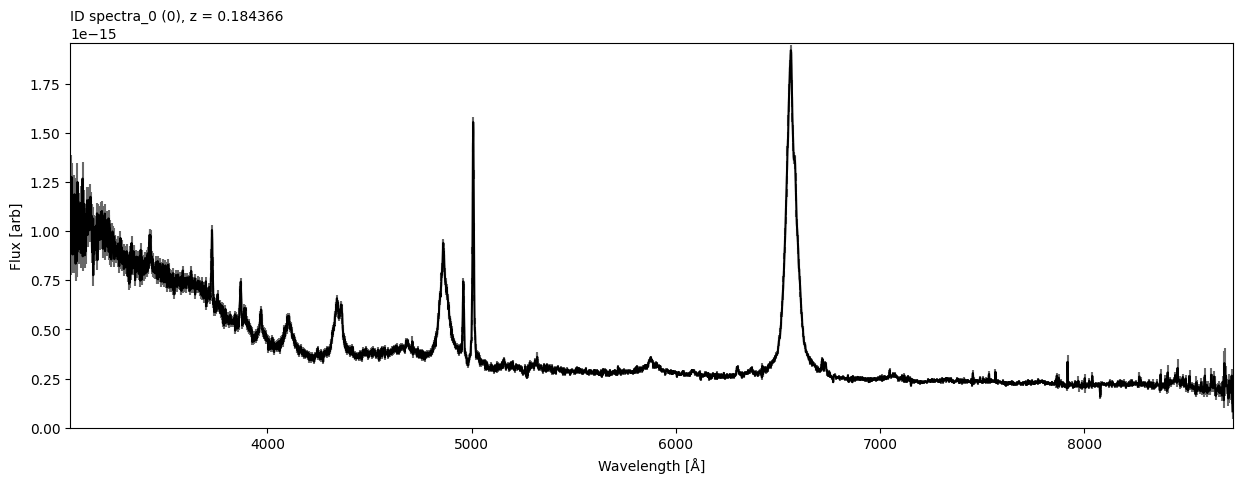

In [6]:
spec_class.quicklook(0)

If a fit is required, call the instance method `make_complex` on the `spec_class`, which initializes the `ComplexBuilder` class. This class loads YAMLs files that contain most known emission lines and creates a `ComplexRegion` instance with all relevant information about the lines and fit regions. It forms the foundation of the fitting process and includes several key parameters:

- `xmin` and `xmax`: wavelength limits for searching emission lines  
- `n_broad` and `n_narrow`: number of broad and narrow components  
- `continuum_profile`: continuum model to use; SHEAP supports `['linear', 'powerlaw', 'brokenpowerlaw', 'logparabola', 'exp_cutoff', 'polynomial']`  
- `fe_mode`: method for estimating the iron contribution; accepted values are `'none'`, `'model'`, and `'template'`  

In the first example, we fit the Hα region (typically 6000–7200 Å) with a linear continuum profile and no iron contribution.

In [79]:
spec_class.makecomplex(6000,7200,n_broad=2,n_narrow=1,fe_mode ="none",continuum_profile="linear",add_winds=False)

In [80]:
spec_class.complexbuild.complex_class

ComplexRegion(lines=[SpectralLine(line_name='broad1', center=[6562.82, 7065.196, 6046.44, 7002.23], region='broad', component=1, subregion=[None, None, None, None], amplitude=[1.0, 1.0, 1.0, 1.0], element=['Hydrogen', 'Helium', 'Oxygen', 'Oxygen'], profile='SPAF', region_lines=['Halpha', 'HeIf', 'OIa', 'OIb'], amplitude_relations=[(0, 1.0, 0), (1, 1.0, 1), (2, 1.0, 2), (3, 1.0, 3)], subprofile=None, rarity=None, template_info=None), SpectralLine(line_name='broad2', center=[6562.82, 7065.196], region='broad', component=2, subregion=[None, None], amplitude=[1.0, 1.0], element=['Hydrogen', 'Helium'], profile='SPAF', region_lines=['Halpha', 'HeIf'], amplitude_relations=[(0, 1.0, 0), (1, 1.0, 1)], subprofile=None, rarity=None, template_info=None), SpectralLine(line_name='linear', center=None, region='continuum', component=0, subregion=None, amplitude=None, element=None, profile='linear', region_lines=None, amplitude_relations=None, subprofile=None, rarity=None, template_info=None), Spectral

When the region is already defined, we can call the other important instance method of the class—`.fitcomplex()`—which invokes the fitting process implemented in the `ComplexFitting` class. Its main parameters are:

- `list_num_steps=[1_000]`: a list containing the number of iterations to perform.  
- `list_learning_rate=[1e-2]`: a list containing the learning rates to try.  
- `run_uncertainty_params=False`: whether to run the uncertainty estimation (we’ll compute uncertainties later).

In this example, we disable uncertainty estimation (`run_uncertainty_params=False`) and compute uncertainties in a separate step. Note that `list_num_steps` and `list_learning_rate` must have the same length, since each entry in `list_learning_rate` is paired with the corresponding number of steps in `list_num_steps`. You can adjust these recommended values to suit your problem.

After fitting, you can visualize the results by calling:

```python
spec_class._plotter.plot()
```

In [81]:
spec_class.fitcomplex(list_num_steps=[1_000],list_learning_rate=[1e-2],run_uncertainty_params=False)

Fitting 2 spectra with 4590 wavelength pixels

STEP1 (step 1) free params 21
learning_rate: 0.01 num_steps: 1000 non_optimize_in_axis: 4
Time for step 'step1': 6.73 seconds
The entire process took 6.73 (3.37s by spectra)


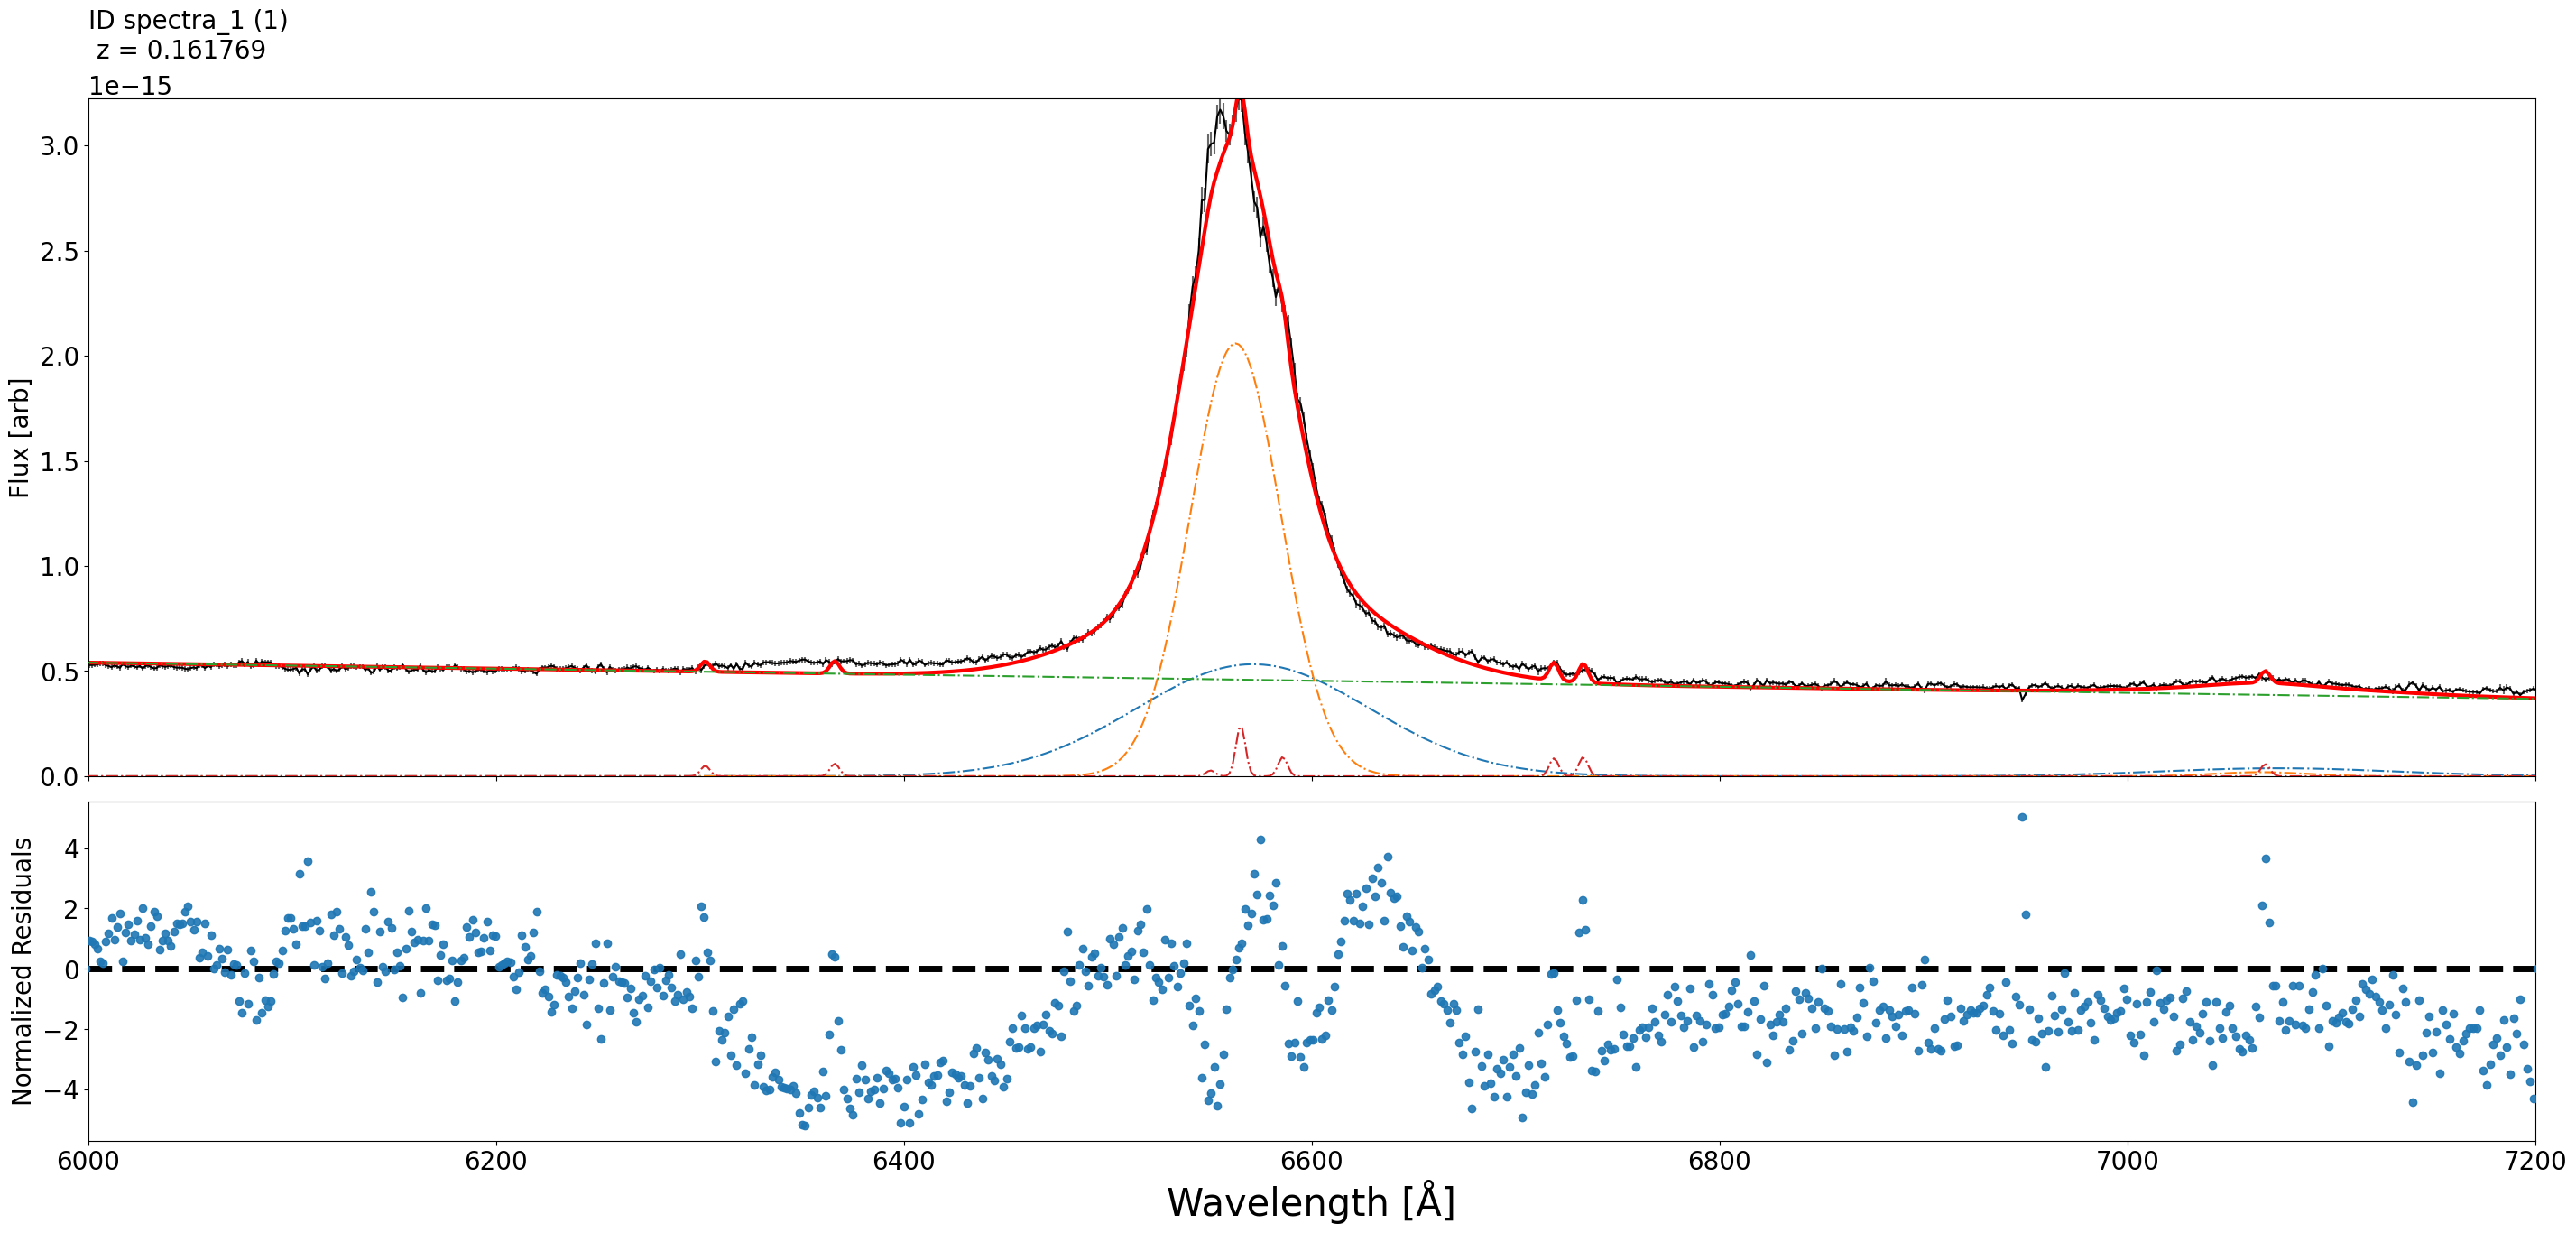

In [82]:
spec_class.modelplot.plot(1,add_name=True)

It is easy to see how poor the fit is, because it requires more components to be fitted effectively. We will see how to improve the fitting in the next notebooks.

Finally, we will show the instance `posterior_params`, which uses the `ComplexAfterFit` class. Currently, SHEAP can handle two types of posterior-parameter estimation:

- The Monte Carlo method  
- MCMC powered by the NumPyro package  

SHEAP can also summarize the samples and estimate posterior parameters such as luminosity, supermassive black hole mass, among others.


In [91]:
spec_class.complexbuild.complex_class.group_by("region")

{'broad': ComplexRegion(lines=[SpectralLine(line_name='broad1', center=[6562.82, 7065.196, 6046.44, 7002.23], region='broad', component=1, subregion=[None, None, None, None], amplitude=[1.0, 1.0, 1.0, 1.0], element=['Hydrogen', 'Helium', 'Oxygen', 'Oxygen'], profile='SPAF_gaussian', region_lines=['Halpha', 'HeIf', 'OIa', 'OIb'], amplitude_relations=[(0, 1.0, 0), (1, 1.0, 1), (2, 1.0, 2), (3, 1.0, 3)], subprofile='gaussian', rarity=None, template_info=None), SpectralLine(line_name='broad2', center=[6562.82, 7065.196], region='broad', component=2, subregion=[None, None], amplitude=[1.0, 1.0], element=['Hydrogen', 'Helium'], profile='SPAF_gaussian', region_lines=['Halpha', 'HeIf'], amplitude_relations=[(0, 1.0, 0), (1, 1.0, 1)], subprofile='gaussian', rarity=None, template_info=None)], profile_functions=[], profile_names=[], params_dict={}, profile_params_index_list=[], params=None, uncertainty_params=None, original_idx=[0, 1], _master_param_names=[], global_profile_params_index_list=[]),

In [93]:
spec_class.afterfit(sampling_method="pseudomontecarlosampler",overwrite=True,summarize=True)

The samples will be summarize is you want to keep the samples summarize=False
No dependencies


Sampling obj:   0%|          | 0/2 [00:00<?, ?it/s]

method pseudomontecarlosampler
2000
dict_keys(['SPAF_gaussian'])
SPAF_gaussian
dict_keys(['SPAF_gaussian'])
SPAF_gaussian


Sampling obj:   0%|          | 0/2 [00:05<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'value'

To study the results, the easiest approach is to use the `result` property of the `spec_class` object. This returns a `ComplexResult` instance that contains the region, parameter results, and, most importantly, the posterior. The posterior is represented as a list where:

1. Index `[0]` holds the basic posterior parameters.  
2. Index `[1]` contains all the line information, organized by the names specified by the user when initializing the code—in this case, `['spectra_0', 'spectra_1']`.  


In [85]:
spec_class.result.posterior[1]['spectra_0']

{'basic_params': {'broad': {'lines': ['Halpha', 'HeIf'],
   'component': [2, 2],
   'flux': array([[4.91121494e-14, 6.71119911e-16],
          [5.13064634e-14, 5.54313634e-18],
          [5.04290181e-14, 4.43688784e-14],
          ...,
          [4.68500781e-14, 4.04848984e-15],
          [4.84107324e-14, 3.82767662e-17],
          [5.18591990e-14, 8.96121392e-19]], shape=(2000, 2)),
   'fwhm': array([[106.78789264, 106.78789264],
          [105.56561386, 105.56561386],
          [107.62068771, 107.62068771],
          ...,
          [110.56480258, 110.56480258],
          [109.48468684, 109.48468684],
          [104.52055175, 104.52055175]], shape=(2000, 2)),
   'fwhm_kms': array([[4871.98427467, 4525.96282234],
          [4816.64053443, 4474.52201152],
          [4910.35229678, 4561.58120534],
          ...,
          [5043.65047007, 4685.47955609],
          [4994.6782049 , 4639.96525679],
          [4769.65182298, 4430.82501569]], shape=(2000, 2)),
   'center': array([[6571.0813116

In [74]:
spec_class.result.posterior[1]['spectra_1']["combined"]

{}

In [35]:
spec_class.result.params[0][5]

Array(71.70493317, dtype=float64)

In [35]:
posterior_single = spec_class.result.posterior[1].copy()

In [42]:
posterior_single["broad"]["fwhm"]

Magnitude,"71.7049, 71.7049, 71.7049, 71.7049, 71.2473, 71.2473, 71.2473, 71.2473"
Error,"0, 0, 0, 0, 0, 0, 0, 0"


When we inspect the resulting dictionary in detail, it contains the following keys:

- `basic_params`: Values for the individual lines in the fit. Since SHEAP groups lines into “templates” that share shift and FWHM, `basic_params` separates these lines for detailed analysis.  
- `L_w` and `L_bol`: The luminosity at a specific wavelength (`L_w`) and the bolometric luminosity (`L_bol`).  
- `extras_params`: Additional parameters for each line. For example, for Hα it includes:  
  - `L_w`  
  - `L_bol`  
  - `fwhm_kms`  
  - `log10_smbh`  
  - `Ledd`  
  - `mdot_msun_per_year`  
- `params_dict_values`: The fitted parameters and their posterior distributions. Note that these parameters remain combined, so their keys follow the pattern `nameparam_linename_region`. For combined lines, `linename = region + component`.  


In [13]:
spec_class.result.posterior[1]["spectra_0"]["params_dict_values"]

{'logamp0_broad1_1_broad': {'median': array([-14.88021528]),
  'err_minus': array([0.00552616]),
  'err_plus': array([0.00595774])},
 'logamp1_broad1_1_broad': {'median': array([-17.86105741]),
  'err_minus': array([1.8258484]),
  'err_plus': array([1.66642955])},
 'logamp2_broad1_1_broad': {'median': array([-19.0768491]),
  'err_minus': array([48.71588371]),
  'err_plus': array([47.43433788])},
 'logamp3_broad1_1_broad': {'median': array([-19.52123631]),
  'err_minus': array([32.40738978]),
  'err_plus': array([30.39564009])},
 'shift_broad1_1_broad': {'median': array([3.05763612]),
  'err_minus': array([0.21006362]),
  'err_plus': array([0.21804236])},
 'fwhm_broad1_1_broad': {'median': array([71.71295714]),
  'err_minus': array([0.54184063]),
  'err_plus': array([0.53691921])},
 'amplitude_slope_linear_0_continuum': {'median': array([-1.35252744e-16]),
  'err_minus': array([1.60295364e-17]),
  'err_plus': array([1.52728414e-17])},
 'amplitude_intercept_linear_0_continuum': {'median'

Finally, to save your results, call the `save_to_pickle` method on the instance.


In [14]:
spec_class.save_to_pickle("dic1.pkl")

Estimated pickle size: 168.64 KB


To load saved results for further testing or new models, use the `from_pickle` class method:

```python
new_instance = YourClass.from_pickle('path/to/your_saved_results.pkl')


In [15]:
spec_class_readed = Sheapectral.from_pickle("dic1.pkl")

To reproduce the same plot, simply call the `_plotter.plot()` method again:

```python
spec_class_readed._fit_instance._plotter.plot()


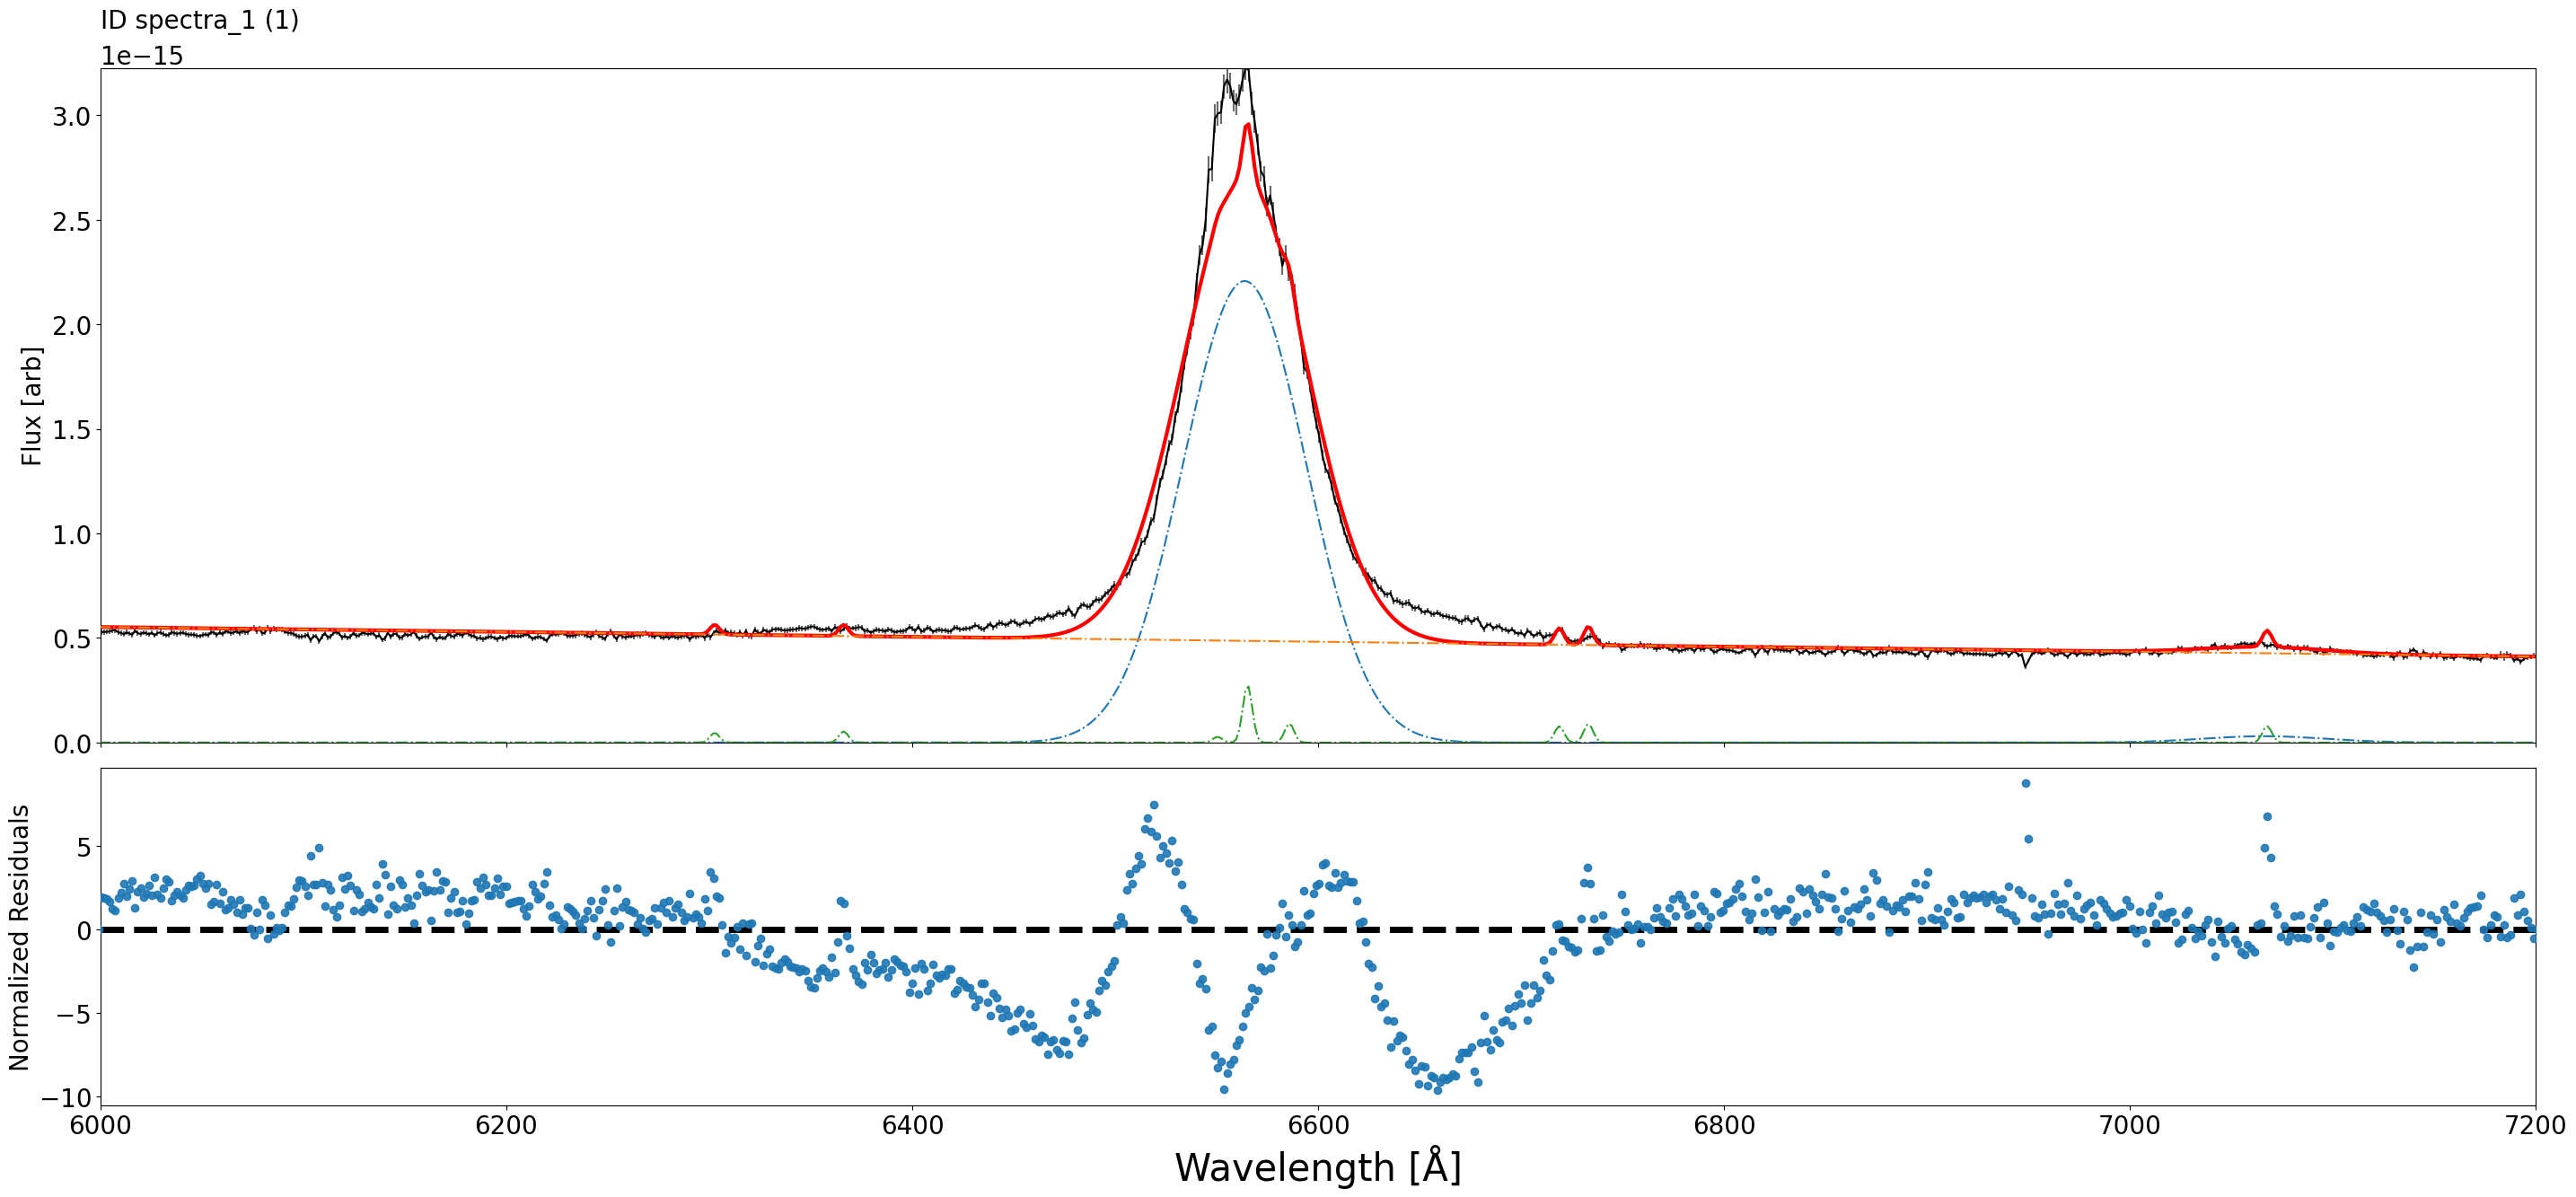

In [16]:
spec_class_readed. _plotter.plot(1,add_name=True)

End example 1.